# Model Training

In [1]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.9.1+cu111
Torchvision Version:  0.10.1+cu111


In [2]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "Data/back_side"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 16

# Number of epochs to train for
num_epochs = 80

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [3]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            else:
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [4]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [5]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(3000),
        transforms.Resize((input_size, input_size)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.5,2), contrast=(0.5,2), saturation=(0.5,2), hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(3000),
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=16) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:3")

Initializing Datasets and Dataloaders...


In [8]:
# Send the model to GPU
model_ft = model_ft.to(device)
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features.9.expand1x1.weight
	 features.

In [9]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/79
----------
train Loss: 0.4182 Acc: 0.8317
val Loss: 0.0980 Acc: 0.9758

Epoch 1/79
----------
train Loss: 0.1855 Acc: 0.9403
val Loss: 0.0829 Acc: 0.9789

Epoch 2/79
----------
train Loss: 0.1534 Acc: 0.9464
val Loss: 0.0831 Acc: 0.9713

Epoch 3/79
----------
train Loss: 0.1236 Acc: 0.9616
val Loss: 0.0807 Acc: 0.9668

Epoch 4/79
----------
train Loss: 0.0937 Acc: 0.9685
val Loss: 0.0537 Acc: 0.9849

Epoch 5/79
----------
train Loss: 0.0700 Acc: 0.9783
val Loss: 0.0600 Acc: 0.9834

Epoch 6/79
----------
train Loss: 0.0996 Acc: 0.9643
val Loss: 0.0442 Acc: 0.9773

Epoch 7/79
----------
train Loss: 0.0620 Acc: 0.9791
val Loss: 0.0620 Acc: 0.9804

Epoch 8/79
----------
train Loss: 0.0529 Acc: 0.9806
val Loss: 0.1546 Acc: 0.9622

Epoch 9/79
----------
train Loss: 0.0607 Acc: 0.9791
val Loss: 0.2034 Acc: 0.9441

Epoch 10/79
----------
train Loss: 0.0627 Acc: 0.9799
val Loss: 0.0223 Acc: 0.9940

Epoch 11/79
----------
train Loss: 0.0422 Acc: 0.9856
val Loss: 0.0378 Acc: 0.9924

Ep

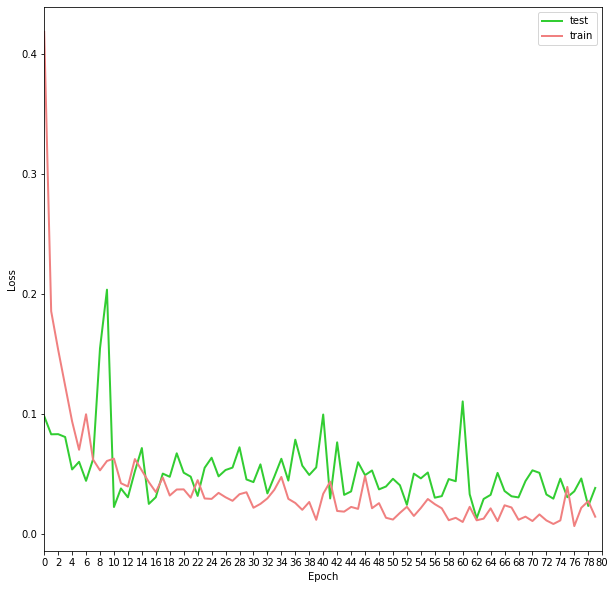

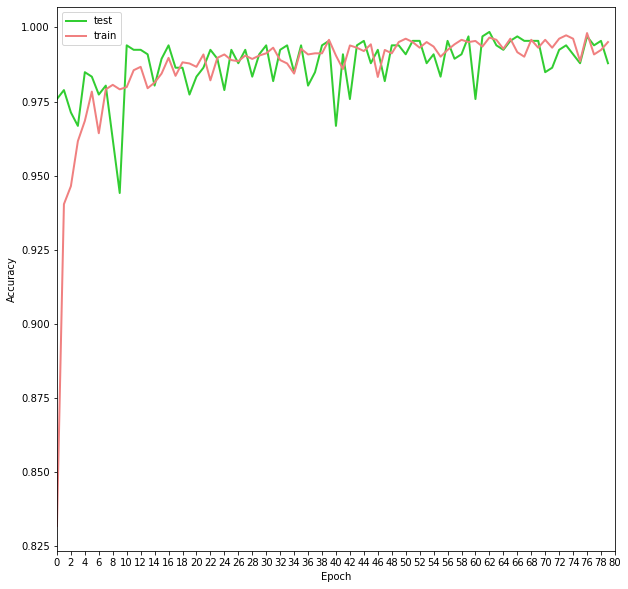

In [10]:
def plot_val_train_hist(num_epochs, val_hist, train_hist, Loss_or_Accuracy = 'Loss'):
    x=np.arange(0,num_epochs,1)
    plt.figure(figsize=(10,10))
    plt.plot(x, val_hist, label='test', color = 'limegreen', linewidth=2)
    plt.plot(x, train_hist, label='train', color = 'lightcoral', linewidth=2)
    plt.xlim([0, num_epochs])
    plt.xticks(np.arange(0,num_epochs+2,2))
    plt.ylabel(Loss_or_Accuracy)
    plt.xlabel('Epoch')
    plt.legend()
    plt.savefig(f'{Loss_or_Accuracy} of model.png', transparent=True, bbox_inches='tight', dpi=600)
    plt.show()
plot_val_train_hist(num_epochs, val_loss_hist, train_loss_hist, 'Loss')
plot_val_train_hist(num_epochs, val_acc_hist, train_acc_hist, 'Accuracy')

In [16]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends torchvision.datasets.ImageFolder"""

    # override the _getitem_ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [17]:
def predict(test_set, model, batch_size):
    
    y_pred = []
    y_true = []
    paths = []
    model.to(device).eval()
    
    test_loader = torch.utils.data.DataLoader(test_set,
            batch_size=batch_size, shuffle=True,
            num_workers=16, pin_memory=False)
    
    
    with torch.no_grad():
        for i, (images, target, path) in enumerate(test_loader):
            images = images.to(device)
            target = target.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)
            
                
            y_pred.extend(preds.view(-1).detach().cpu().numpy())
            y_true.extend(target.view(-1).detach().cpu().numpy())
            paths.extend(path)

    return y_pred, y_true, paths

In [18]:
test_dataset = ImageFolderWithPaths(f"{data_dir}/val", data_transforms["val"])
pred, true, paths = predict(test_dataset, model_ft, batch_size)
torch.save(model_ft, 'Strawberry_model_back_side.pth')

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib

In [20]:
def plot_matrix(cm, classes="", name="confusion_matrix"):
    matplotlib.rcParams['font.sans-serif'] = ['Uuntu Mono'] 
    matplotlib.rcParams['font.serif'] = ['Uuntu Mono'] 
    f, ax= plt.subplots(figsize = (15, 15))
    sns.heatmap(cm, cmap="Greens", fmt='.2f', annot=True, annot_kws={"size": 18}, vmax = 1, vmin=0, linewidths=.5, square=True, ax=ax)  #annot_kws={"size": 44}
    
    for text in ax.texts:
        if float(text.get_text()) <  cm.max() / 2:
            text.set_color("darkslategray")
    ax.set_yticklabels(classes, fontsize=18, rotation=0)
    ax.set_xticklabels(classes, fontsize=18, rotation=45)
    ax.set_ylabel('True', fontsize=24, fontweight ='bold')
    ax.set_xlabel('Predicted', fontsize=24, fontweight ='bold')

    plt.savefig(f'{name}.jpg', transparent=True, bbox_inches='tight', dpi=600)
    plt.show()

In [36]:
print(image_datasets['val'].classes)
print(pred)
print(true)

['06_leaf_blight_sunburn_r', '08_angular_leaf_spot_r', '12_health_r']
[0, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0,

In [5]:
pred = [0, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 2, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0]
true = [0, 0, 0, 2, 0, 2, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 1, 0, 2, 2, 0, 2, 2, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1, 2, 1, 0, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 2, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2, 1, 0, 1, 2, 2, 0, 0, 2, 0, 1, 2, 1, 1, 2, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 0, 1, 2, 2, 1, 0, 2, 2, 2, 1, 1, 0, 2, 2, 1, 2, 1, 2, 0, 0, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 2, 0, 1, 0, 0, 1, 2, 2, 0, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 0, 1, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 2, 1, 2, 0, 0, 1, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 2, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 2, 0, 1, 1, 1, 2, 1, 1, 0, 0, 2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 2, 1, 0, 2, 1, 1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 1, 0, 2, 1, 2, 1, 2, 2, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2, 0, 2, 2, 1, 1, 0, 2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 0, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1, 1, 1, 0, 1, 2, 0, 0, 0, 2, 0, 2, 1, 2, 0, 2, 1, 1, 1, 2, 0, 0, 2, 0, 1, 2, 2, 2, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 0, 1, 1, 0, 2, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 1, 0, 0, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 1, 0, 1, 2, 0, 1, 0, 1, 1, 0, 2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 0, 1, 2, 1, 0, 1, 1, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Accuracy : 0.9984894259818731
Confusion Matrix :
 [[201   1   0]
 [  0 258   0]
 [  0   0 202]]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


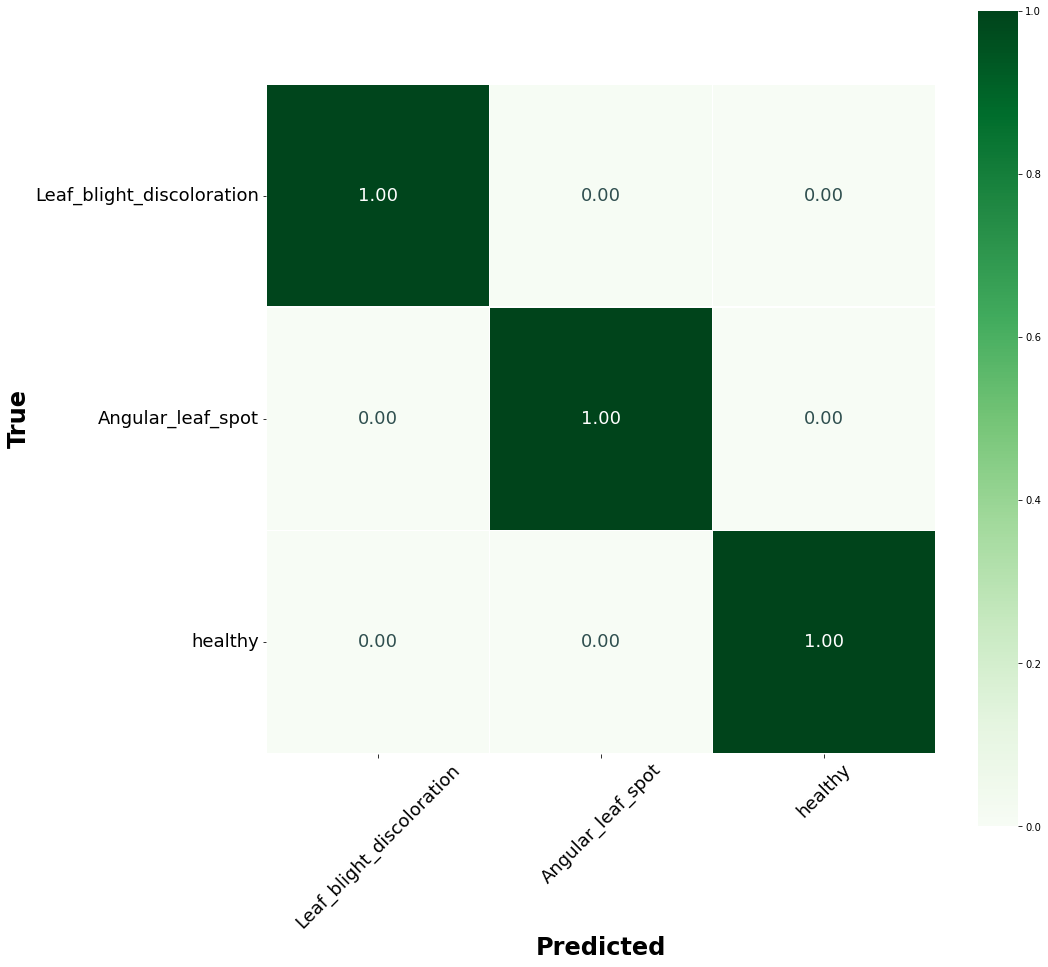

In [21]:
import matplotlib.pyplot as plt
acc_score = accuracy_score(true, pred)
cm = confusion_matrix(true, pred, normalize="false")
nor_cm = confusion_matrix(true, pred, normalize="true")
print(f'Accuracy : {acc_score}')
print(f'Confusion Matrix :\n {cm}')
new_val_classes = ['Leaf_blight_discoloration',
                   'Angular_leaf_spot',
                   'healthy'
                  ]
plot_matrix(nor_cm, new_val_classes,'Normalized Confusion Matrix')

In [51]:
print(image_datasets['val'].classes)

['06_leaf_blight_sunburn_r', '08_angular_leaf_spot_r', '12_health_r']


# Data Analysis

In [23]:
import os
import os.path
import sys
import shutil
from PIL import Image

In [ ]:
for name in new_val_classes:
    globals()[f'Correct_{name}'] = []
    globals()[f'Wrong_{name}'] = []
    
for (pred_, true_, path_) in zip(pred, true, paths):
    if pred_ != true_ :
        globals()[f'Wrong_{new_val_classes[true_]}'].append((path_, pred_))
        i+=1
    else:
        globals()[f'Correct_{new_val_classes[true_]}'].append((path_, pred_))
        
        
for name in new_val_classes:
    print(globals()[f'Wrong_{name}'])

print(f'Total number of misidentification : {i}')
for name in new_val_classes:
    print(globals()[f'Correct_{name}'])

In [30]:
analysis_path = 'Analysis'

#the path of the test data
val_path = 'Data/back_side/val'

correct_path = f'{analysis_path}/back_side/correct'
wrong_path = f'{analysis_path}/back_side/wrong'

correctGradCAM_path=f'{analysis_path}/backside/correctGradCAM'
wrongGradCAM_path=f'{analysis_path}/backside/wrongGradCAM'

val_list : ['06_leaf_blight_sunburn_r', '08_angular_leaf_spot_r']

new_val_classes : ['Leaf_blight_sunburn_R', 'Angular_leaf_spot_R']

disease_dic : {'06_leaf_blight_sunburn_r': 'Leaf_blight_sunburn_R', '08_angular_leaf_spot_r': 'Angular_leaf_spot_R'}


In [ ]:
val_list = sorted(os.listdir(val_path))

#create a dic to change the diseases name  
disease_dic = {}
for i in range(len(val_list)):
    disease_dic[val_list[i]] = new_val_classes[i]

In [36]:
for disease in val_list:
    os.makedirs(f'{correct_path}/{disease}', exist_ok=True)
    os.makedirs(f'{wrong_path}/{disease}', exist_ok=True)
    print(globals()[f'Correct_{disease_dic[disease]}'])
    correct_class_name = globals()[f'Correct_{disease_dic[disease]}']
    worng_class_name = globals()[f'Wrong_{disease_dic[disease]}']
    
    for i in range(len(worng_class_name)):
        worng_img_path = worng_class_name[i][0]
        pred_label = worng_class_name[i][1]
        pred_disease = new_val_classes[pred_label]
        print(f'{wrong_path}/{disease}/{pred_disease}_{str(i)}.JPG')

[('/home/nas/Research_Group/Personal/TzuWei/Project/Strawberry/Data/back_side/val/06_leaf_blight_sunburn_r/leaf_blight_sunburn_r_2022_01_14_DSC_0108.JPG', 0), ('/home/nas/Research_Group/Personal/TzuWei/Project/Strawberry/Data/back_side/val/06_leaf_blight_sunburn_r/leaf_blight_sunburn_r_2022_02_16_DSC_0182.JPG', 0), ('/home/nas/Research_Group/Personal/TzuWei/Project/Strawberry/Data/back_side/val/06_leaf_blight_sunburn_r/leaf_blight_sunburn_r_2022_02_16_DSC_0193.JPG', 0), ('/home/nas/Research_Group/Personal/TzuWei/Project/Strawberry/Data/back_side/val/06_leaf_blight_sunburn_r/leaf_blight_sunburn_r_2022_01_14_DSC_0050.JPG', 0), ('/home/nas/Research_Group/Personal/TzuWei/Project/Strawberry/Data/back_side/val/06_leaf_blight_sunburn_r/leaf_blight_sunburn_r_2022_02_16_DSC_0934.JPG', 0), ('/home/nas/Research_Group/Personal/TzuWei/Project/Strawberry/Data/back_side/val/06_leaf_blight_sunburn_r/leaf_blight_sunburn_r_2022_01_14_DSC_0074.JPG', 0), ('/home/nas/Research_Group/Personal/TzuWei/Project/

In [26]:
for disease in val_list:
    os.makedirs(f'{correct_path}/{disease}', exist_ok=True)
    os.makedirs(f'{wrong_path}/{disease}', exist_ok=True)
    
    correct_class_name = globals()[f'Correct_{disease_dic[disease]}']
    worng_class_name = globals()[f'Wrong_{disease_dic[disease]}']
    
    for i in range(len(worng_class_name)):
        worng_img_path = worng_class_name[i][0]
        pred_label = worng_class_name[i][1]
        pred_disease = new_val_classes[pred_label]
        img = Image.open(worng_img_path)
        img.save(f'{wrong_path}/{disease}/{pred_disease}_{str(i)}.jpg')
    
    for i in range(len(correct_class_name)):
        correct_img_path = correct_class_name[i][0]
        pred_label = correct_class_name[i][1]
        pred_disease = new_val_classes[pred_label]
        img = Image.open(correct_img_path)
        img.save(f'{correct_path}/{disease}/{pred_disease}_{str(i)}.jpg')

In [27]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import models
import torch
from torchvision import transforms
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image
import matplotlib.pyplot as plt

In [28]:
#input_size is the size of image in your model
#target is the output of your class,
# you can choose the target with ClassifierOutputTarget,
# if you want to see the class[0] in your result,
# you can set target=[ClassifierOutputTarget(0)],
# if tatget is None, the highest scoring category will be used
def my_grad_cam(img_path, save_path, input_size, cam, targets = None):
    #read img and transfer to input_tensor
    rgb_img = cv2.imread(img_path, 1)[:, :, ::-1]
    plt.imshow(rgb_img)
    rgb_img = cv2.resize(rgb_img, (input_size, input_size))
    rgb_img = np.float32(rgb_img) / 255
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    input_tensor = transform(rgb_img)
    input_tensor = input_tensor.view(1, 3, input_size, input_size)
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    visualization = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
    cv2.imwrite(save_path,visualization)

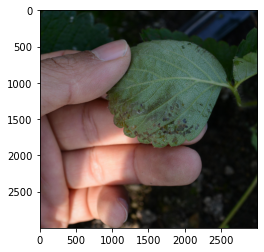

In [34]:
os.makedirs(correctGradCAM_path, exist_ok=True)
os.makedirs(wrongGradCAM_path, exist_ok=True)

target_layers = [model_ft.features[-1]]
cam = GradCAM(model=model_ft, target_layers=target_layers, use_cuda=True)

for disease in val_list:
    os.makedirs(f'{correctGradCAM_path}/{disease}', exist_ok=True)
    os.makedirs(f'{wrongGradCAM_path}/{disease}', exist_ok=True)
    
    correct_pic_list = os.listdir(f'{correct_path}/{disease}')
    wrong_pic_list = os.listdir(f'{wrong_path}/{disease}')
    
    for img_name in correct_pic_list:
        try:                      
            img_path = f'{correct_path}/{disease}/{img_name}'
            save_path = f'{correctGradCAM_path}/{disease}/{img_name}'
            my_grad_cam(img_path, save_path, input_size, cam)
        except:                   
            print('OSError, Path:', f'{correct_path}/{disease}/{img_name}')
            correct_pic_list.remove(img_name)
    
    for img_name in wrong_pic_list:
        try:                      
            img_path = f'{wrong_path}/{disease}/{img_name}'
            save_path = f'{wrongGradCAM_path}/{disease}/{img_name}'
            my_grad_cam(img_path, save_path, input_size, cam)
        except:                   
            print('OSError, Path:', f'{correct_path}/{disease}/{img_name}')
            correct_pic_list.remove(img_name)